<font size="8"><b>PREDICTING FLIGHT DELAYS</b></font>

<font size="6"><b>Random Forest - Balanced </b></font>

![Figure_11](img/Figure_11.png)

At this point of the project I believe the data is relatively clean to start going into the modeling part. I will start by loading the data, doing a quick QC to check once again that everything is in place and then I will check the data distribution (is the data is balance or not?). However, I will do this as part of following a standard workflow as it is clear that this dataset is unbalanced. How do I know this? remember that in one of my documents (The Preprocessing_and_Cleaning notebook), I engineered a binary column called "Flight Status", where a 0 corresponds to a flight that arrives on time, and a 1 to a delayed flight. Just in case you are wondering how I treated the negative values for the arrivals, I considered them as arriving on time, even when it mean you arrived earlier.  

Any conclusion or comments that I have made based on the EDA done will be put aside until I come up with other conclusions based on my models and then I will try to tie them up. 

One last comment before I start is that this is a sandbox, so there will be a few of this documents to avoid having an extremely large one. Most probably one per algorithm.

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

from sklearn import metrics, linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from random import sample

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelBinarizer

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

Using TensorFlow backend.


# Data Loading & QC

In [2]:
dfm = pd.read_csv('dfm.csv', index_col=0)
dfm.head()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,MONTH,FLIGHT_STATUS,WEEKDAY
0,United Airlines,Newark,Denver,3,-5.0,3,268.0,250.0,225.0,1605.0,1,0,0
1,United Airlines,Las Vegas,San Francisco,2,-8.0,3,99.0,83.0,65.0,414.0,1,0,0
2,United Airlines,Santa Ana,Denver,3,-5.0,3,134.0,126.0,106.0,846.0,1,0,0
3,United Airlines,Ft. Myers,Chicago,3,6.0,3,190.0,182.0,157.0,1120.0,1,0,0
6,United Airlines,Houston,Las Vegas,2,-3.0,2,206.0,193.0,173.0,1222.0,1,0,0


In [3]:
dfm.CRS_DEP_TIME.value_counts(normalize=True)

2    0.383851
3    0.365520
4    0.180862
1    0.069767
Name: CRS_DEP_TIME, dtype: float64

In [4]:
dfm.CRS_ARR_TIME.value_counts(normalize=True)

3    0.352446
2    0.313633
4    0.307612
1    0.026308
Name: CRS_ARR_TIME, dtype: float64

In [5]:
dfm.WEEKDAY.value_counts(normalize=True)

0    0.150824
4    0.149288
3    0.148301
2    0.145013
1    0.143541
6    0.141507
5    0.121525
Name: WEEKDAY, dtype: float64

In [6]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4008257 entries, 0 to 7213445
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   OP_CARRIER           object 
 1   ORIGIN               object 
 2   DEST                 object 
 3   CRS_DEP_TIME         int64  
 4   DEP_DELAY            float64
 5   CRS_ARR_TIME         int64  
 6   CRS_ELAPSED_TIME     float64
 7   ACTUAL_ELAPSED_TIME  float64
 8   AIR_TIME             float64
 9   DISTANCE             float64
 10  MONTH                int64  
 11  FLIGHT_STATUS        int64  
 12  WEEKDAY              int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 428.1+ MB


In [7]:
dfm.shape

(4008257, 13)

In [8]:
dfm.isna().sum()

OP_CARRIER             0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_DELAY              0
CRS_ARR_TIME           0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
MONTH                  0
FLIGHT_STATUS          0
WEEKDAY                0
dtype: int64

# Data Distribution

I already know that this dataset is unbalanced, but just to follow standard workflows I will write a short function to see this visually and then keep on going.

In [9]:
def scaling_check(data):
    
    case_count = dfm['FLIGHT_STATUS'].value_counts() # 'data' is our input which will be any of the 3 dataframes created
    print('Legend:')
    print(case_count)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=case_count.index, y=case_count.values)
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.title('Data Distribution', fontsize=16)
    plt.xlabel('Flight Status', fontsize=12)
    plt.ylabel('Number of Flights', fontsize=12)
    plt.xticks(range(len(case_count.index)), ['ON TIME(0)', 'DELAYED(1)'])
    plt.show()

Legend:
0    2518941
1    1489316
Name: FLIGHT_STATUS, dtype: int64


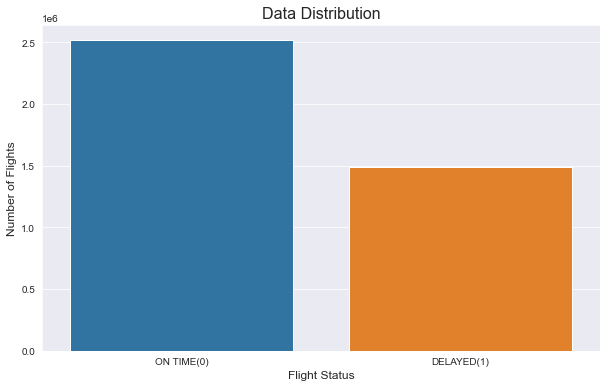

In [10]:
scaling_check(dfm)

In [11]:
dfm.FLIGHT_STATUS.value_counts(normalize=True)

0    0.628438
1    0.371562
Name: FLIGHT_STATUS, dtype: float64

As mentioned above, the data is unbalance with a 62.84% of the flights arriving on time and 37.16% being delayed. For the time being I will keep it this way but if results are not adequate I will come back to this and try to balance it. At the moment is less than 2:1 ratio so the problem is there but it is not insanely big.

<b>Weight calculation for each class</b>

In [12]:
dfm.head(2)

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,MONTH,FLIGHT_STATUS,WEEKDAY
0,United Airlines,Newark,Denver,3,-5.0,3,268.0,250.0,225.0,1605.0,1,0,0
1,United Airlines,Las Vegas,San Francisco,2,-8.0,3,99.0,83.0,65.0,414.0,1,0,0


In [13]:
dfm.FLIGHT_STATUS.value_counts()

0    2518941
1    1489316
Name: FLIGHT_STATUS, dtype: int64

In [14]:
count_0 = 2518941
count_1 = 1489316

In [15]:
print(count_0)
print(count_1)

2518941
1489316


In [16]:
initial_bias = np.log([count_1/count_0])
initial_bias

weight_for_0 = (1/count_0)*(count_0 + count_1)/2.0
weight_for_1 = (1/count_1)*(count_0 + count_1)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.80
Weight for class 1: 1.35


As for the previous Random Forest I'll quickly display histogram to better understand the data and just in case you are looking only at this one and not the V1.

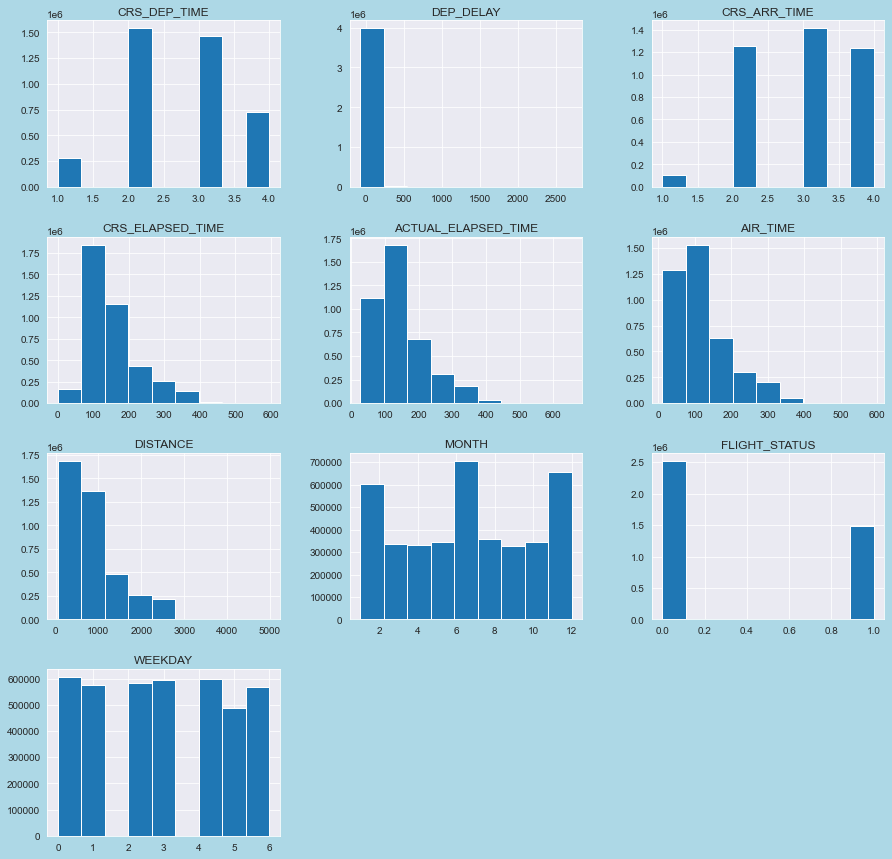

In [17]:
dfm.hist(figsize  = [15, 15],bins=9) 
plt.show()

In [18]:
dfm.DEP_DELAY.value_counts(normalize=True)

-5.0       7.605326e-02
-4.0       7.301079e-02
-3.0       7.088767e-02
-6.0       6.475732e-02
-2.0       6.441179e-02
               ...     
 1315.0    2.494850e-07
 1121.0    2.494850e-07
 1317.0    2.494850e-07
 1321.0    2.494850e-07
-57.0      2.494850e-07
Name: DEP_DELAY, Length: 1432, dtype: float64

In [19]:
dfm_test=dfm[(dfm['DEP_DELAY'] > 1000)]
dfm_test

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,MONTH,FLIGHT_STATUS,WEEKDAY
7521,SkyWest Airlines,Eau Claire,Chicago,1,1041.0,2,82.0,73.0,48.0,269.0,1,1,0
8227,SkyWest Airlines,Atlanta,Chicago,3,1140.0,3,130.0,134.0,95.0,606.0,1,1,0
14275,American Airlines,Eagle,Dallas-Fort Worth,3,1144.0,4,133.0,124.0,93.0,721.0,1,1,0
14636,American Airlines,Detroit,Dallas-Fort Worth,3,1013.0,4,189.0,177.0,135.0,986.0,1,1,0
21972,Spirit Airlines,Detroit,Denver,3,1332.0,4,202.0,215.0,158.0,1123.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202763,United Airlines,Eagle,Newark,3,1306.0,4,241.0,206.0,180.0,1725.0,12,1,0
7203678,Endeavor Air,Traverse City,Detroit,3,1231.0,4,78.0,73.0,40.0,207.0,12,1,0
7211246,SkyWest Airlines,Minneapolis,Houston,4,1074.0,4,192.0,186.0,156.0,1034.0,12,1,0
7212368,SkyWest Airlines,Aspen,San Francisco,4,1041.0,4,156.0,141.0,104.0,848.0,12,1,0


# Categoricals

In [20]:
dfm.columns

Index(['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY',
       'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'MONTH', 'FLIGHT_STATUS', 'WEEKDAY'],
      dtype='object')

I have a few Categoricals to deal with:<br>

* OP_CARRIER = 18 airlines<br>
* ORIGIN = 20 cities<br>
* DEST = 20 cities<br>
* CRS_DEP_TIME = 4 quarters<br>
* CRS_ARR_TIME = 4 quarters<br>
* MONTH = 12 months<br>
* FLIGHT_STATUS = 2 categories (already dealt with)<br>
* WEEKDAY = 7 days (from 0 to 6)



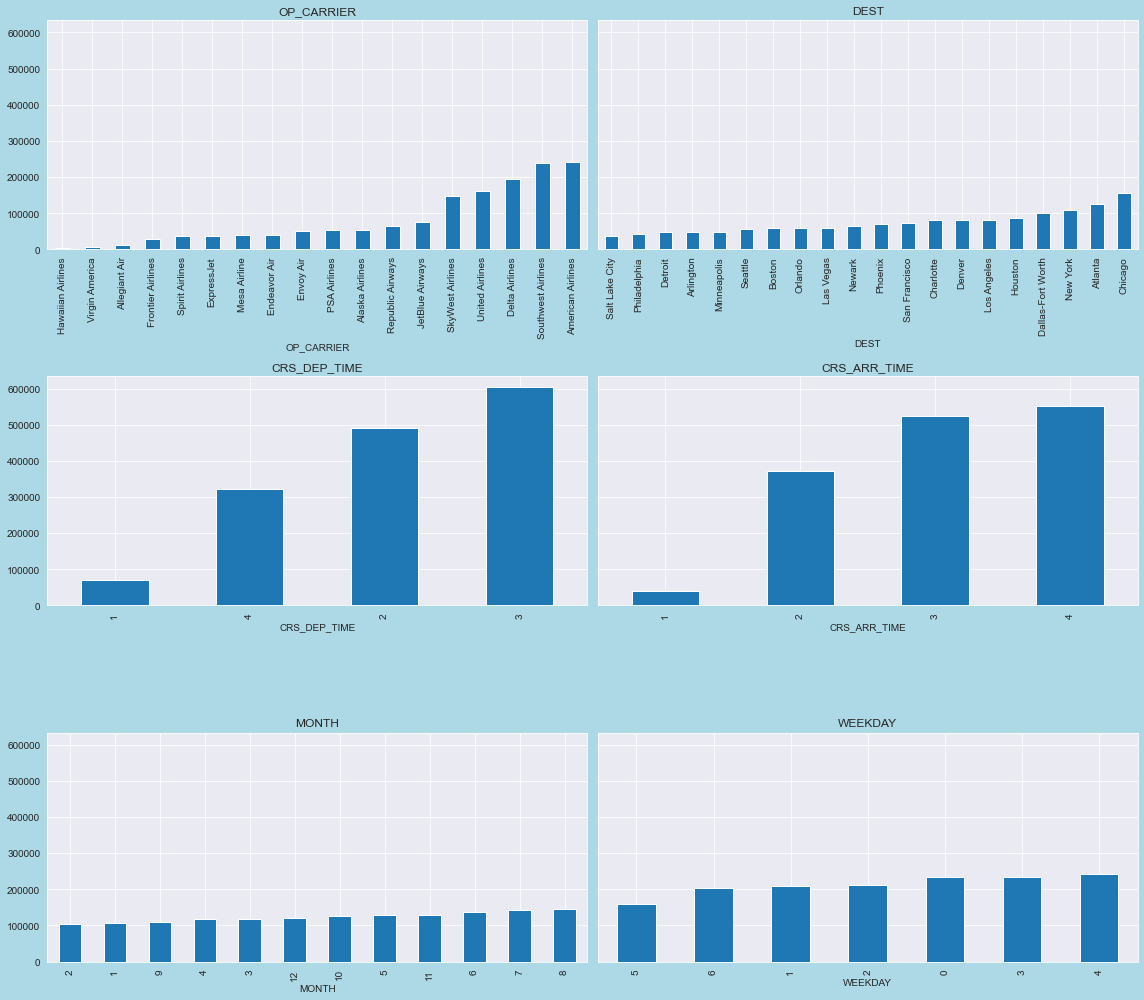

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,14), sharey=True)

categoricals = ['OP_CARRIER', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'WEEKDAY']

for col, ax in zip(categoricals, axes.flatten()):
    (dfm.groupby(col).sum()['FLIGHT_STATUS'].sort_values().plot.bar(ax=ax))
    
    ax.set_title(col)
    
fig.tight_layout()


In [22]:
OP_CARRIER_dummies = pd.get_dummies(dfm['OP_CARRIER'], prefix='OP_CARRIER', drop_first=True)
DEST_dummies = pd.get_dummies(dfm['DEST'], prefix='DEST', drop_first=True)
CRS_DEP_TIME_dummies = pd.get_dummies(dfm['CRS_DEP_TIME'], prefix='CRS_DEP_TIME', drop_first=True)
CRS_ARR_TIME_dummines = pd.get_dummies(dfm['CRS_ARR_TIME'], prefix='CRS_ARR_TIME', drop_first=True) 
MONTH_dummies = pd.get_dummies(dfm['MONTH'], prefix='MONTH', drop_first=True)
WEEKDAY_dummies = pd.get_dummies(dfm['WEEKDAY'], prefix='WEEKDAY', drop_first=True)

In [23]:
dfm = dfm.drop(['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'WEEKDAY', 'ACTUAL_ELAPSED_TIME'], axis=1)

In [24]:
dfm = pd.concat([dfm, OP_CARRIER_dummies, DEST_dummies, CRS_DEP_TIME_dummies, CRS_ARR_TIME_dummines, MONTH_dummies, WEEKDAY_dummies], axis=1)

In [25]:
dfm.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,268.0,225.0,1605.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,99.0,65.0,414.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
dfm.shape

(4008257, 64)

In [66]:
dfm.to_csv('dfm_ready.csv')

# Random Forest

## Features, Labels, Training and Test Data Creation

In [27]:
# Create features (X) and labels (y)
y = dfm['FLIGHT_STATUS']
X = dfm.drop(['FLIGHT_STATUS', 'DEP_DELAY'], axis=1)

In [28]:
# Perform the split
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25, random_state=42)

## Build Regular Tree as Baseline

In [29]:
# Build a regular tree as baseline
#class_weight = {0:0.3715 ,1:0.6284}
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, class_weight="balanced")
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

Before I continue, I'll run a importance feature values and then plot them to see which ones are the ones with thee most weight. 

In [30]:
tree_clf.feature_importances_

array([0.05775774, 0.11195425, 0.02872367, 0.        , 0.        ,
       0.15612776, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02470708, 0.        , 0.        , 0.        ,
       0.00347836, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00236146, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03174274, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03781775,
       0.        , 0.        , 0.37125813, 0.        , 0.12666622,
       0.        , 0.        , 0.        , 0.00438225, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00569018,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03733241, 0.        ])

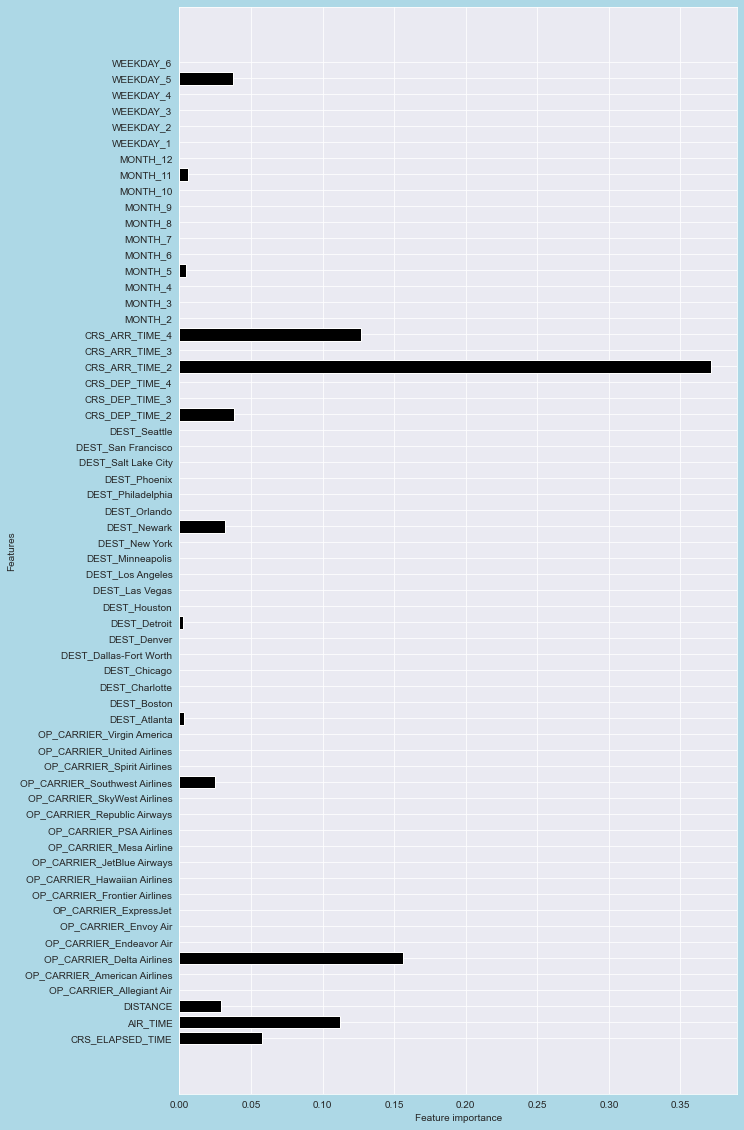

In [31]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 20))
    plt.barh(range(n_features), model.feature_importances_, color='k', align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.grid(True)
plot_feature_importances(tree_clf)

<b>Model Performance</b>

In [32]:
# Test set predictions
pred = tree_clf.predict(X_test)

In [33]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1111401,778007,1889408
1,491669,625115,1116784
All,1603070,1403122,3006192


In [34]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.69      0.59      0.64   1889408
           1       0.45      0.56      0.50   1116784

    accuracy                           0.58   3006192
   macro avg       0.57      0.57      0.57   3006192
weighted avg       0.60      0.58      0.58   3006192



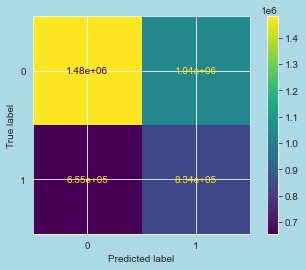

In [35]:
# Alternative confusion matrix
plot_confusion_matrix(tree_clf, X, y, values_format='.3g')
plt.show()

In [36]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 57.76%


<b>BAGGED TREES</b>

In [37]:
# We start by instantiating the BaggingClassifire
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [38]:
# Now to fitting the training data:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [39]:
# I'm going to call the .score() to obtain the accuracy score on the training dataset and then on the test data:
bagged_tree.score(X_train, y_train)

0.6366383418241331

In [40]:
bagged_tree.score(X_test, y_test)

0.6368355713806703

<b>MODEL PERFORMANCE</b>

In [41]:
# Test set predictions
pred_bt = bagged_tree.predict(X_test)

In [42]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_bt, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1822592,66816,1889408
1,1024926,91858,1116784
All,2847518,158674,3006192


In [43]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_bt))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.64      0.96      0.77   1889408
           1       0.58      0.08      0.14   1116784

    accuracy                           0.64   3006192
   macro avg       0.61      0.52      0.46   3006192
weighted avg       0.62      0.64      0.54   3006192



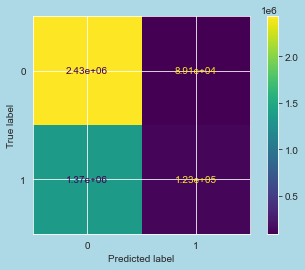

In [44]:
# Alternative confusion matrix
plot_confusion_matrix(bagged_tree, X, y, values_format='.3g')
plt.show()

In [45]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred_bt) * 100))

Testing Accuracy for Decision Tree Classifier: 63.68%


## Random Forest With Class Weighting

In [46]:
# I'll start by instantiating the RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight="balanced")
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [47]:
# Now to check the accuracy score
forest.score(X_train, y_train)

0.5676817372126559

In [48]:
# And for the test set:
forest.score(X_test, y_test)

0.5676240905437843

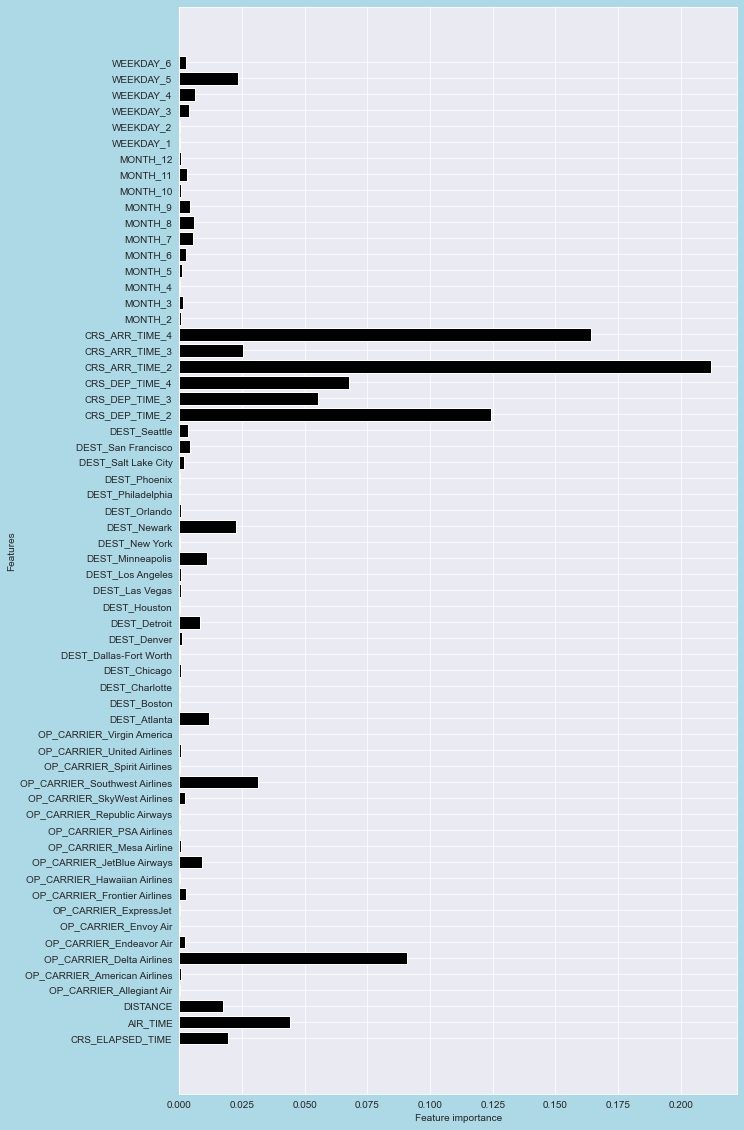

In [49]:
plot_feature_importances(forest)
plt.rcParams["figure.facecolor"] = "lightblue"

<b>MODEL PERFORMANCE</b>

In [50]:
# Test set predictions
pred_rf = forest.predict(X_test)

In [51]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1047432,841976,1889408
1,457829,658955,1116784
All,1505261,1500931,3006192


In [52]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_rf))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.70      0.55      0.62   1889408
           1       0.44      0.59      0.50   1116784

    accuracy                           0.57   3006192
   macro avg       0.57      0.57      0.56   3006192
weighted avg       0.60      0.57      0.57   3006192



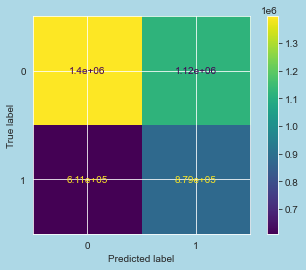

In [53]:
# Alternative confusion matrix
plot_confusion_matrix(forest, X, y, values_format='.3g')
plt.show()

In [54]:
print("Testing Accuracy for RandomForest Classifier: {:.4}%".format(accuracy_score(y_test, pred_rf) * 100))

Testing Accuracy for RandomForest Classifier: 56.76%


In [55]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [56]:
# evaluate model
#scores = cross_val_score(forest, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)


In [57]:
# summarize performance
#print('Mean ROC AUC: %.3f' % mean(scores))

## Random Forest With Bootstrat Class Weighting

In [58]:
forest_bcw = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced_subsample')
forest_bcw.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5)

In [59]:
# Now to check the accuracy score
forest_bcw.score(X_train, y_train)

0.5708921077973984

In [60]:
# And for the test set:
forest_bcw.score(X_test, y_test)

0.570811179059754

<b>MODEL PERFORMANCE</b>

In [61]:
# Test set predictions
pred_rfbcw = forest_bcw.predict(X_test)

In [62]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_rfbcw, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1065639,823769,1889408
1,466455,650329,1116784
All,1532094,1474098,3006192


In [63]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_rfbcw))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.70      0.56      0.62   1889408
           1       0.44      0.58      0.50   1116784

    accuracy                           0.57   3006192
   macro avg       0.57      0.57      0.56   3006192
weighted avg       0.60      0.57      0.58   3006192



In [64]:
print("Testing Accuracy for RandomForest Classifier: {:.4}%".format(accuracy_score(y_test, pred_rfbcw) * 100))

Testing Accuracy for RandomForest Classifier: 57.08%
